In [211]:
import pandas as pd
import duckdb as ddb
from urllib.parse import urlparse

In [212]:
# Function to extract the domain (e.g., www.usnews.com)
def extract_domain(url):
    domain = urlparse(url).netloc
    return domain

In [ ]:
# Function to extract the necessary data from DataFrame
def extract_info(df):
    df.submission_date = pd.to_datetime(df.submission_date)
    df.comment_date = pd.to_datetime(df.comment_date)

    submissions_per_author = ddb.sql(
        "SELECT submission_author, COUNT(DISTINCT submission_title) AS submission_count FROM df GROUP BY submission_author ORDER BY submission_count DESC"
    )
    comments_per_comment_author = ddb.sql(
        "SELECT comment_author, COUNT(DISTINCT comment_text) AS comments_count FROM df GROUP BY comment_author ORDER BY comments_count DESC"
    )
    submission_urls_count = ddb.sql(
        "SELECT submission_url, COUNT(submission_url) AS submission_count FROM (SELECT DISTINCT submission_title, submission_url FROM df) GROUP BY submission_url ORDER BY submission_count DESC"
    )
    submission_urls_count_per_author = ddb.sql(
        "SELECT submission_author, submission_url, COUNT(submission_url) AS count FROM (SELECT DISTINCT submission_author, submission_date, submission_title, submission_url FROM df) GROUP BY submission_author, submission_url ORDER BY count DESC"
    )
    submissions_author_commenter = ddb.sql(
        "SELECT DISTINCT submission_author, submission_title, comment_text, submission_url FROM df WHERE submission_author = comment_author"
    )
    author_commenter_comments_count = ddb.sql(
        "SELECT submission_author, COUNT(comment_text) AS comments_count FROM submissions_author_commenter GROUP BY submission_author ORDER BY comments_count DESC"
    )
    top_submissions = ddb.sql(
        "SELECT DISTINCT submission_score, submission_upvote_ratio, submission_author, submission_url, submission_title FROM df ORDER BY submission_score DESC"
    )
    comments_per_hour = ddb.sql(
        "SELECT DATE_TRUNC('hour', comment_date) AS date, COUNT(comment_text) AS comments_count FROM df GROUP BY date ORDER BY date"
    )
    submissions_per_hour = ddb.sql(
        "SELECT DATE_TRUNC('hour', submission_date) AS date, COUNT(DISTINCT submission_title) AS submissions_count FROM df GROUP BY date ORDER BY date"
    )

    return (
        submissions_per_author,
        comments_per_comment_author,
        submission_urls_count,
        submission_urls_count_per_author,
        submissions_author_commenter,
        author_commenter_comments_count,
        top_submissions,
        comments_per_hour,
        submissions_per_hour,
    )

## Extract data for analysis

In [214]:
df = pd.read_csv("csvs/top/politics/politics_top_week_2025_03_15.csv")

df.submission_url = df.submission_url.apply(extract_domain)
(
    submissions_per_author,
    comments_per_comment_author,
    submission_urls_count,
    submission_urls_count_per_author,
    submissions_author_commenter,
    author_commenter_comments_count,
    top_submissions,
    comments_per_hour,
    submissions_per_hour,
) = extract_info(df)

df.sample(1)

,submission_date,submission_score,submission_upvote_ratio,submission_title,submission_selftext,submission_author,comment_date,comment_score,comment_author,comment_text,comment_is_submitter,submission_permalink,submission_url
55861,2025-03-12 14:31:51,4595,0.96,Vandalize Tesla Property And The White House W...,NaN,T_Shurt,2025-03-12 15:29:16,8,BubbleGumCrash,This makes sense if they're considering the at...,False,/r/politics/comments/1j9lfrp/vandalize_tesla_p...,fortune.com


In [215]:
top_submissions

┌──────────────────┬─────────────────────────┬────────────────────┬───────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ submission_score │ submission_upvote_ratio │ submission_author  │    submission_url     │                                                                                                  submission_title                                                                                                  │
│      int64       │         double          │      varchar       │        varchar        │                                                                                                      varchar                                                                                                       │
├──────────────────┼─────────────────────────┼────────────────────┼──────────────────

## Visualize data

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

<Axes: xlabel='submission_count', ylabel='submission_url'>

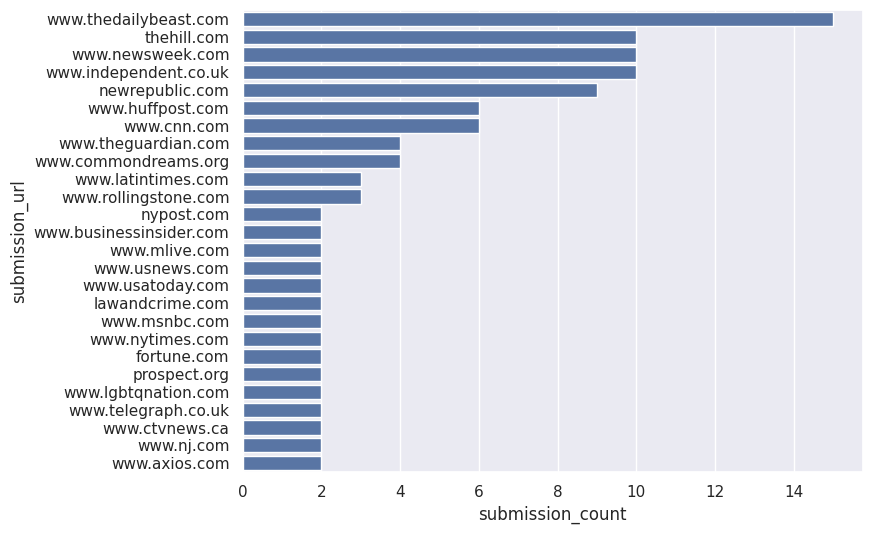

In [217]:
dbdf = ddb.sql("select * from submission_urls_count where submission_count > 1").df()
dbdf = dbdf.set_index("submission_url")
plt.figure(figsize=(8, 6))
sns.barplot(y=dbdf.index, x=dbdf.submission_count)

In [218]:
dbdf = ddb.sql(
    "select submission_title, date_trunc('hour', comment_date) AS date, count(comment_text) as comments_count from df group by date, submission_title order by submission_title, date"
).df()
dbdf.date = pd.to_datetime(dbdf.date)
dbdf = dbdf.set_index(dbdf.date).drop("date", axis=1)

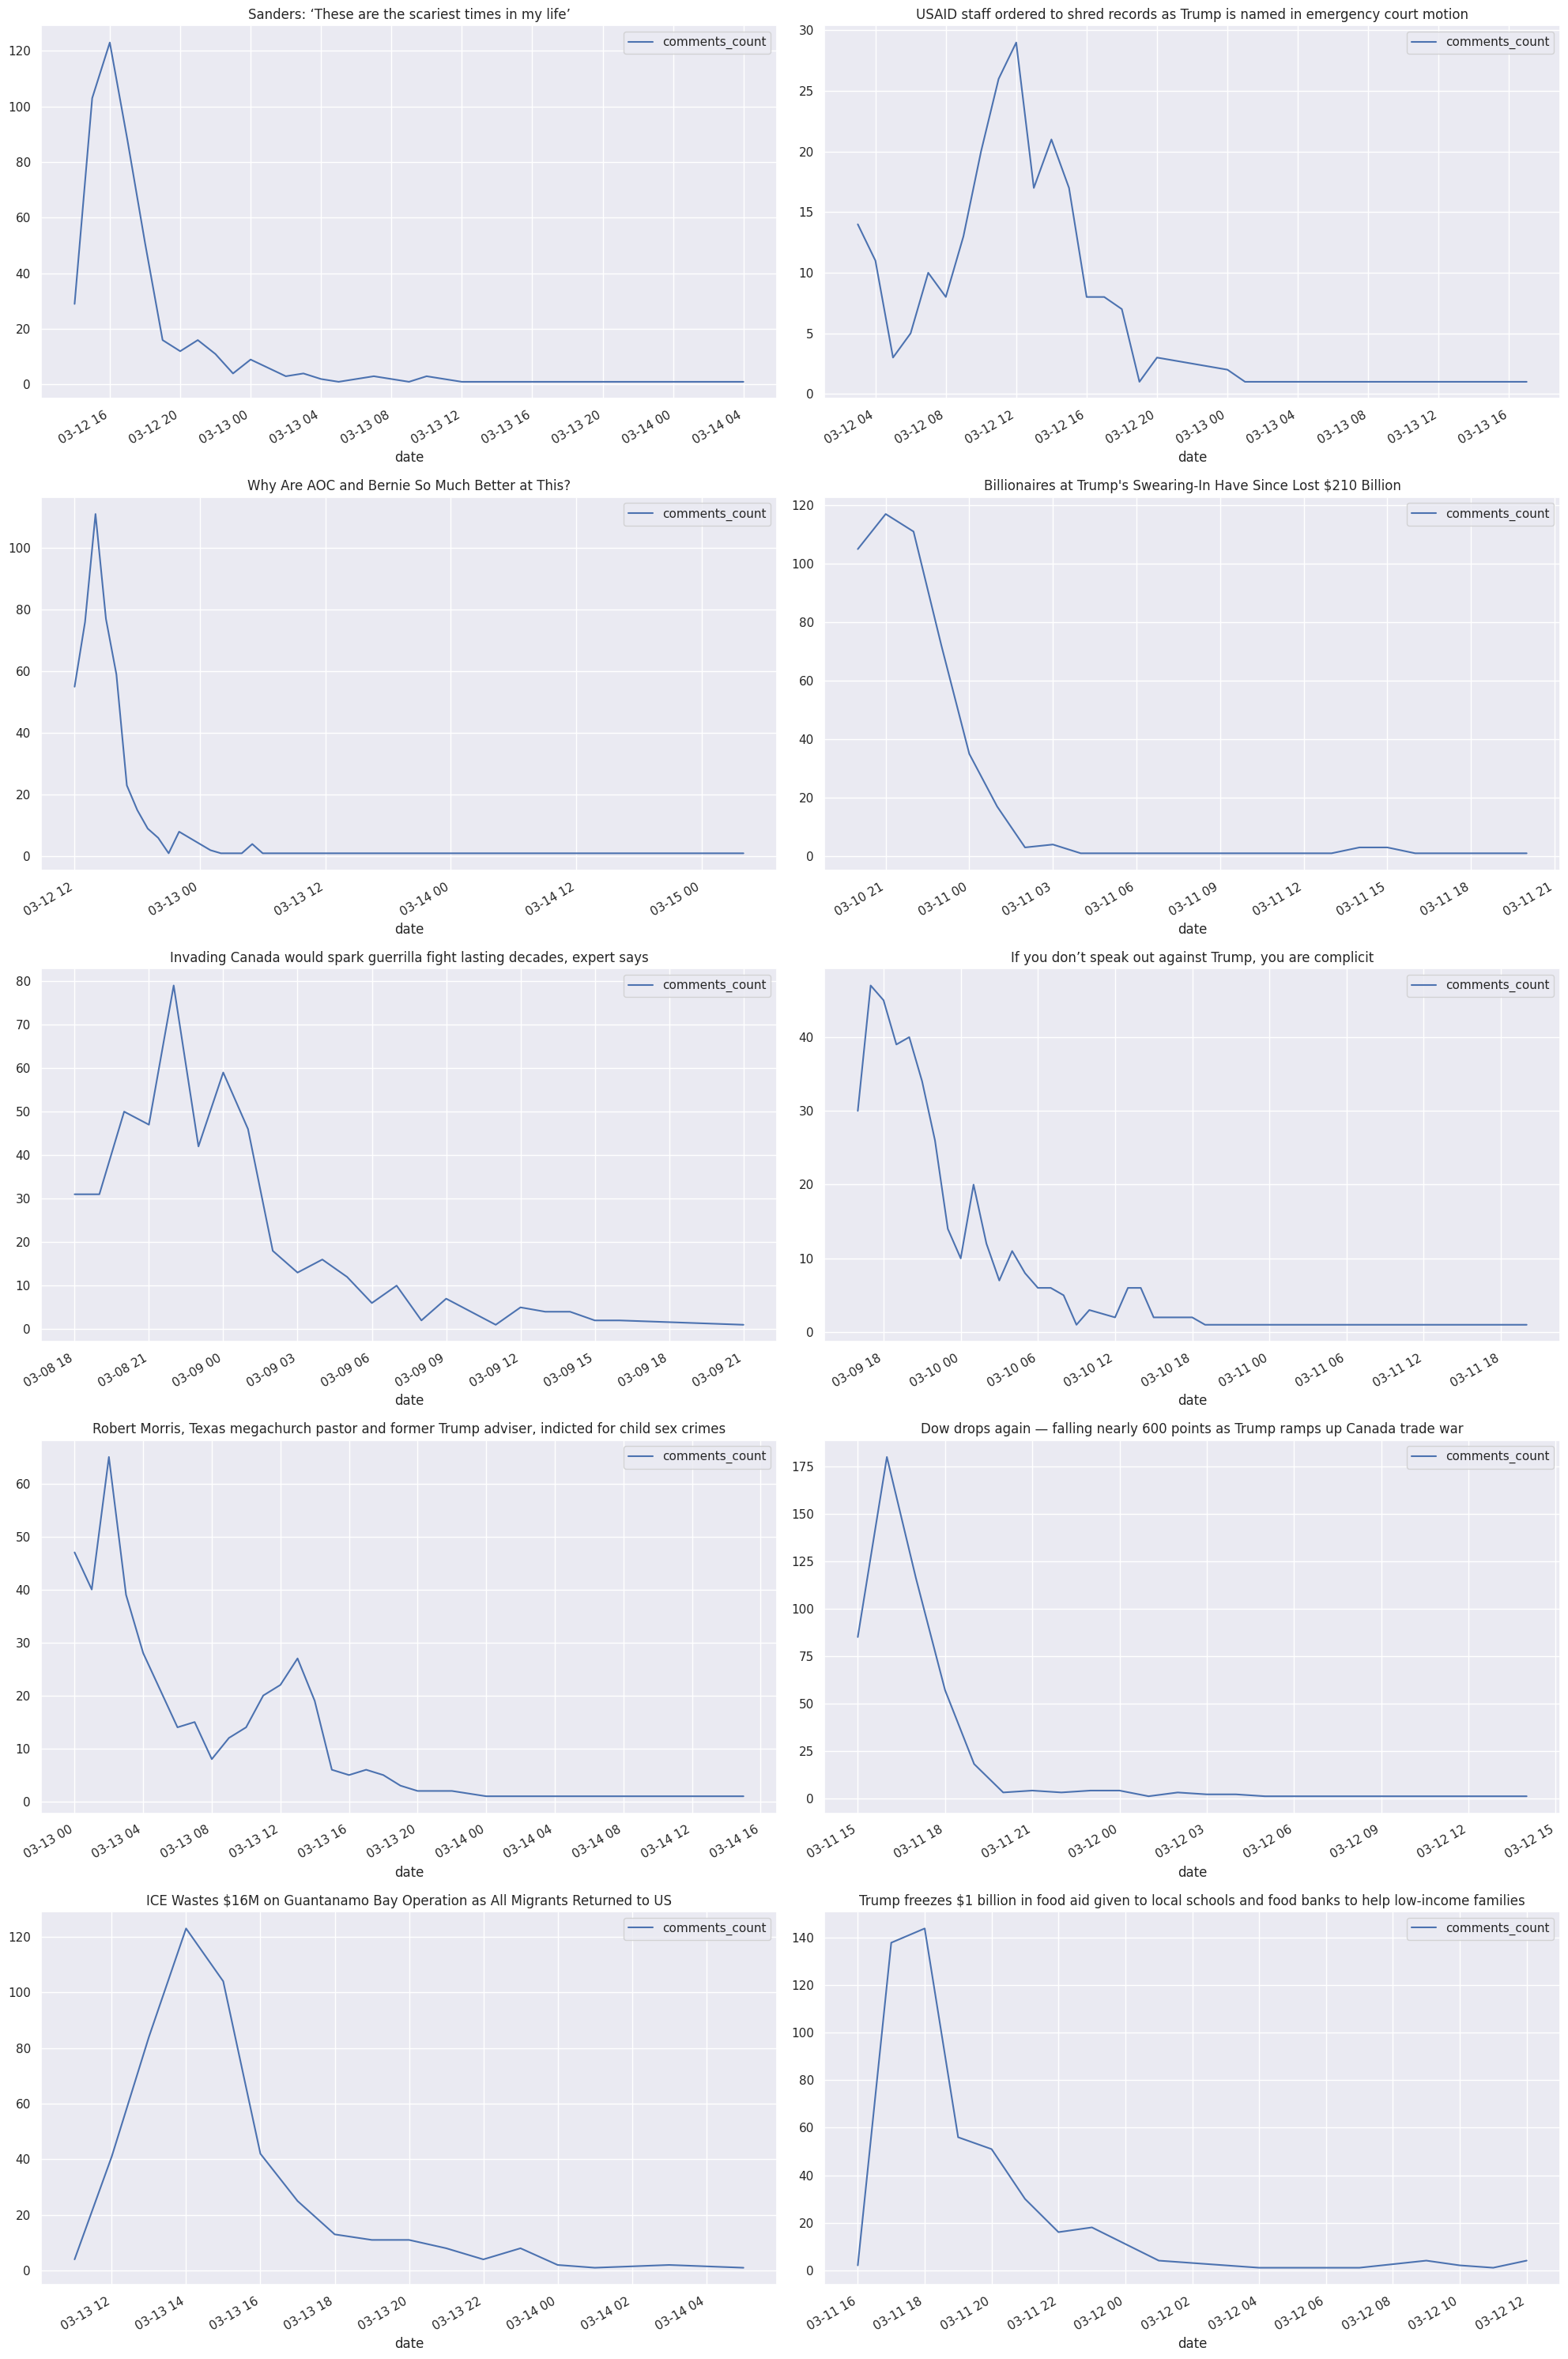

In [219]:
titles = list(set(dbdf.submission_title))[:10]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
axes = axes.flatten()

for ax, title in zip(axes, titles):
    subset = dbdf[dbdf.submission_title == title]
    subset.plot(ax=ax, title=title)

plt.tight_layout()
plt.show()

<Axes: xlabel='date'>

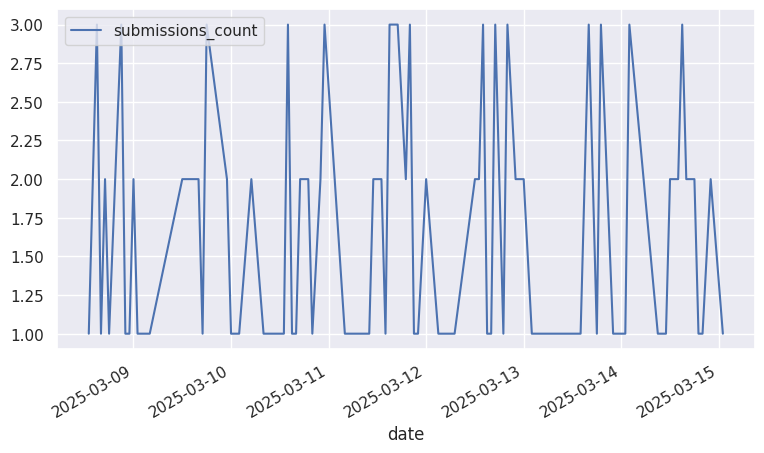

In [220]:
sph = submissions_per_hour.to_df()
sph.index = sph.date
sph = sph.drop("date", axis=1)
sph.plot(figsize=(9, 5))

<Axes: xlabel='date'>

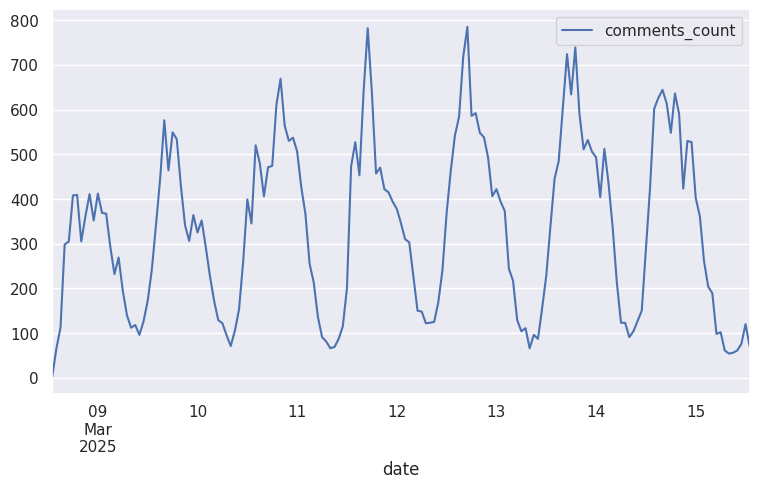

In [221]:
cph = comments_per_hour.to_df()
cph.index = cph.date
cph = cph.drop("date", axis=1)
cph.plot(figsize=(9, 5))